# Chest X-Ray Images (Pneumonia) Classification


## Loading the Dataset

In [1]:
pip install livelossplot

In [7]:
#Getting Data from the google drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
#Extracting data from the zip file

from zipfile import ZipFile
file_name = '/content/gdrive/MyDrive/Colab Notebooks/chest_xray.zip'

with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    #zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!


In [9]:
#Importing Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf 
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from livelossplot.inputs.keras import PlotLossesCallback

#Importing Models
from tensorflow.keras.applications.vgg16 import VGG16

In [10]:
path_train='chest_xray/train'
path_test='chest_xray/test'
images_train=[]
images_test=[]
y=[]

for folder in os.listdir(path_train):
    if folder!=".DS_Store":
        for file in os.listdir(os.path.join(path_train,folder)):
                images_train.append(os.path.join(path_train, os.path.join(folder,file)))
np.random.shuffle(images_train)

for folder in os.listdir(path_test):
    if folder!=".DS_Store":
        for file in os.listdir(os.path.join(path_test,folder)):
                if folder=='NORMAL':
                    y1=0
                else:
                    y1=1
                y.append(y1)
                images_test.append(os.path.join(path_test, os.path.join(folder,file)))
                

## Data Augmentation and Generation

In [11]:
def data_aug(bsize,path_train,path_test):
  #Defining different types of geometries
  train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
  test_datagen = ImageDataGenerator(rescale = 1.0/255.)

  #Generating images
  train_generator = train_datagen.flow_from_directory(path_train, batch_size = bsize, class_mode = 'binary', target_size = (224, 224))
  test_generator = test_datagen.flow_from_directory(path_test, batch_size = bsize, class_mode = 'binary', target_size = (224, 224))
  return train_generator,test_generator


## Call Back Parameters

In [27]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath="gdrive/MyDrive/Colab Notebooks",
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# ModelCheckpoint callback - save best weights
tl_checkpoint_2 = ModelCheckpoint(filepath="gdrive/MyDrive/Colab Notebooks",
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop2 = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

## Adding End Layers

In [13]:
def add_layers(base_model,d1,drp,act1,act2):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(base_model.output)
  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(d1, activation=act1)(x)
  # Add a dropout rate of 0.5
  x = layers.Dropout(drp)(x)
  # Add a final sigmoid layer with 1 node for classification output
  x = layers.Dense(1, activation=act2)(x)
  return x

# Model01- VGG16

## Loading the Pre trained Data

In [14]:
#Loading the pretrained model
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58900480/58889256 [==============================] - 0s 0us/step


## Defining the non training layers

In [15]:
#Setting the layers not being trained as false
for layer in base_model.layers:
  layer.trainable = False

## Adding additional layers

In [16]:
#Defining the end layers
x=add_layers(base_model,512,0.5,'relu','sigmoid')

## Compiling the model

In [19]:
#Compiling the model and defining the optimizer,loss function and the accuracy metrics
vggmodel = tf.keras.models.Model(base_model.input, x)
print(vggmodel.summary())
vggmodel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy',metrics = ['acc'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Fitting the Model

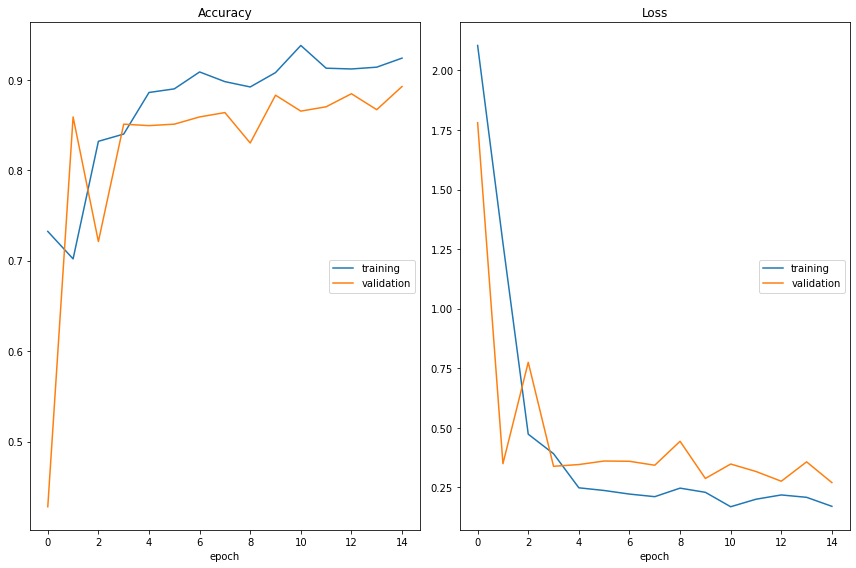

Accuracy
	training         	 (min:    0.702, max:    0.938, cur:    0.924)
	validation       	 (min:    0.428, max:    0.893, cur:    0.893)
Loss
	training         	 (min:    0.168, max:    2.105, cur:    0.170)
	validation       	 (min:    0.270, max:    1.780, cur:    0.270)
10/10 [==============================] - 25s 3s/step - loss: 0.1701 - acc: 0.9240 - val_loss: 0.2696 - val_acc: 0.8926
Duration for VGG16: 0:07:42.620607


In [20]:
print('\nDataset Details')
bsize=50
train_vgg,test_vgg=data_aug(bsize,path_train,path_test)
print('\nTraining VGG 16 model')
#Getting the time
start_vgg=datetime.now()

#Accuracy and loss plot
plot_loss_1 = PlotLossesCallback()

vgghist=vggmodel.fit(train_vgg, 
                  validation_data = test_vgg, 
                  steps_per_epoch = 10, 
                  epochs = 15,
                  # validation_steps=1,
                  callbacks=[tl_checkpoint_1, early_stop,plot_loss_1],
                  verbose=1)
end_vgg=datetime.now()
print('Duration for VGG16: {}'.format(end_vgg-start_vgg))

# Model02- InceptionV3

## Loading Pre trained Data

In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model_incep = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 3s 0us/step


## Defining non training layers

In [22]:
for layer in base_model_incep.layers:
  layer.trainable = False

## Adding additional layers and compiling model

In [25]:
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras import layers, Model

#Calling the adding layers function
x1=add_layers(base_model_incep,1024,0.2,'relu','sigmoid')

#Compiling the model
modelv3= tf.keras.models.Model(base_model_incep.input, x1)
print(modelv3.summary())
modelv3.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['acc'])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

## Fitting the model

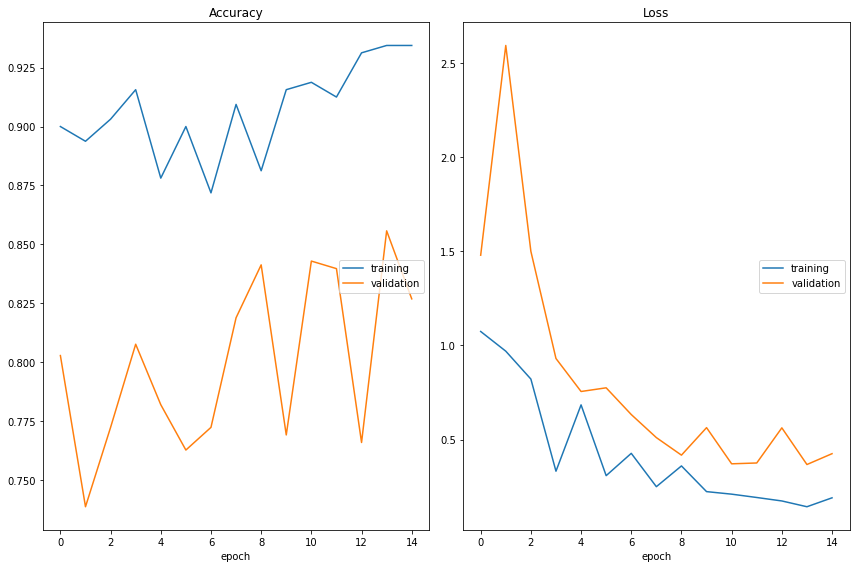

Accuracy
	training         	 (min:    0.872, max:    0.934, cur:    0.934)
	validation       	 (min:    0.739, max:    0.856, cur:    0.827)
Loss
	training         	 (min:    0.143, max:    1.074, cur:    0.191)
	validation       	 (min:    0.368, max:    2.594, cur:    0.425)
10/10 [==============================] - 16s 2s/step - loss: 0.1908 - acc: 0.9344 - val_loss: 0.4253 - val_acc: 0.8269
Duration for inceptionV3: 0:12:05.681499


In [28]:
print('\nDataset Details')
bsize=32
train_v3,test_v3=data_aug(bsize,path_train,path_test)


print('\nTraining Inception V3 model')
#Calculating Time
start_v3=datetime.now()

#Accuracy and loss plot
plot_loss_2 = PlotLossesCallback()

inc_history = modelv3.fit(train_v3, 
                        validation_data = test_v3, 
                        steps_per_epoch = 10, 
                        epochs = 15,
                        callbacks=[tl_checkpoint_2, early_stop2,plot_loss_2],
                        verbose=1)
end_v3=datetime.now()
print('Duration for inceptionV3: {}'.format(end_v3-start_v3))

# Performance comparison between VGG16 & InceptionV3

## Passing images to the model

In [29]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

yhatvgg=[]
yhatv3=[]
for img in images_test:
  # load an image from file
  image = load_img(img, target_size=(224, 224))

  # convert the image pixels to a numpy array
  image = img_to_array(image)
  # reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  # prepare the image for the VGG model
  image = preprocess_input(image)

  # predict the probability across all output classes
  yhat1 = vggmodel.predict(image)
  yhat2 = modelv3.predict(image)
  if yhat1>=0.5:
     yhat1=1
  else:
    yhat1=0
  
  if yhat2>=0.5:
     yhat2=1
  else:
    yhat2=0
  yhatvgg.append(yhat1)
  yhatv3.append(yhat2)

## Classified and Missclassified Examples

Some correctly classified images for Object Classification using VGG16

Classified as Normal


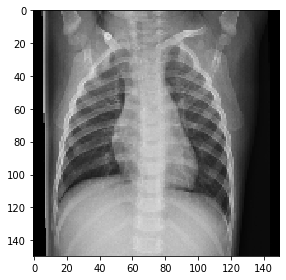


Classified as Pneumonia


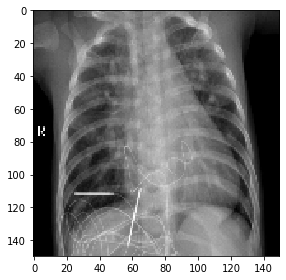

Some Missclassified images for Object Classification using VGG16

Classified as Pneumonia


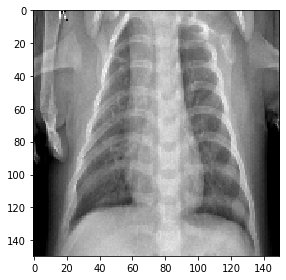


Classified as Normal


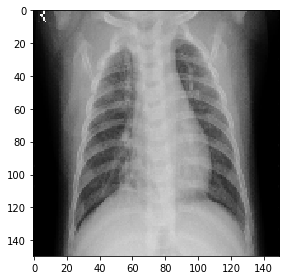

In [56]:
import cv2
from skimage import io, data, exposure, morphology

def readImage(img_path):
    img = io.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def show(img):
    io.imshow(img)
    plt.show()

vgg_mismatch=[]
vgg_match=[]
count=0
for i in yhatvgg:
    if i!=y[count]:
        vgg_mismatch.append(count)
    else:
        vgg_match.append(count)
    count=count+1
# print(len(vgg_mismatch))
# print(len(vgg_match))


#Correctly Classified
print('Some correctly classified images for Object Classification using VGG16')
print('\nClassified as '+str(Index[yhatvgg[svm_match[1]]]))
img1=readImage(images_test[svm_match[1]])
show(img1)
print('\nClassified as '+str(Index[yhatvgg[svm_match[434]]]))
img3=readImage(images_test[svm_match[434]])
show(img3)

#Not Correctly Classified
print('Some Missclassified images for Object Classification using VGG16')
print('\nClassified as '+str(Index[yhatvgg[svm_mismatch[0]]]))
img5=readImage(images_test[svm_mismatch[0]])
show(img5)
print('\nClassified as '+str(Index[yhatvgg[svm_mismatch[100]]]))
img7=readImage(images_test[svm_mismatch[100]])
show(img7)

281
343
Some correctly classified images for Object Classification using InceptionV3

Classified as Normal


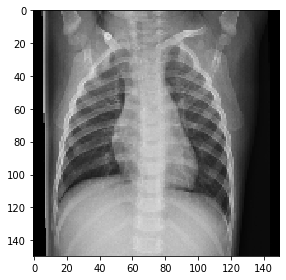


Classified as Pneumonia


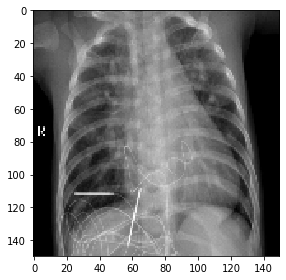

Some Missclassified images for Object Classification using InceptionV3

Classified as Pneumonia


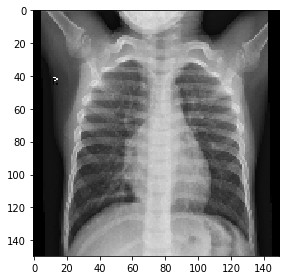


Classified as Pneumonia


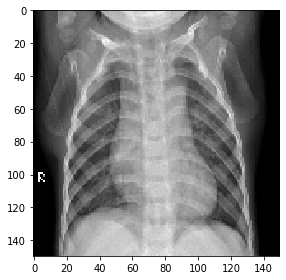

In [60]:
v3_mismatch=[]
v3_match=[]
count=0
for i in yhatv3:
    if i!=y[count]:
        v3_mismatch.append(count)
    else:
        v3_match.append(count)
    count=count+1
print(len(v3_mismatch))
print(len(v3_match))

#Correctly Classified
print('Some correctly classified images for Object Classification using InceptionV3')
print('\nClassified as '+str(Index[yhatv3[v3_match[1]]]))
img2=readImage(images_test[v3_match[1]])
show(img2)
print('\nClassified as '+str(Index[yhatv3[v3_match[342]]]))
img4=readImage(images_test[v3_match[342]])
show(img4)

#Not Correctly Classified
print('Some Missclassified images for Object Classification using InceptionV3')
print('\nClassified as '+str(Index[yhatv3[v3_mismatch[0]]]))
img6=readImage(images_test[v3_mismatch[0]])
show(img6)
print('\nClassified as '+str(Index[yhatv3[v3_mismatch[100]]]))
img7=readImage(images_test[v3_mismatch[100]])
show(img7)

## Confusion Matrix

Duration for Training VGG16 Model: 0:07:42.620607
Duration for Training InceptionV3 Model: 0:12:05.681499

Accuracy for VGG16 Model: 0.6971153846153846
Accuracy for Inception Model: 0.5496794871794872




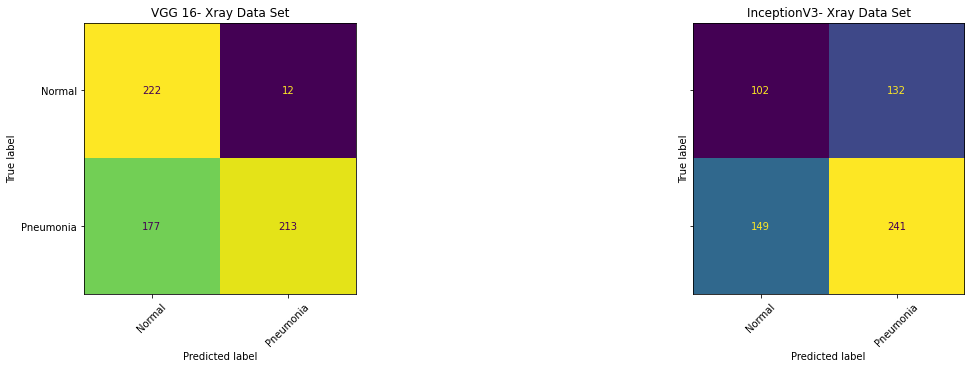

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
#Printing Duration
print('Duration for Training VGG16 Model: {}'.format(end_vgg-start_vgg))
print('Duration for Training InceptionV3 Model: {}\n'.format(end_v3-start_v3))

#Printing the Accuracy
print("Accuracy for VGG16 Model: "+str(accuracy_score(y, yhatvgg)))
print("Accuracy for Inception Model: "+str(accuracy_score(y, yhatv3)))
print('\n')

f, axes = plt.subplots(1, 2, figsize=(20, 5), sharey='row')
Index= ['Normal','Pneumonia']

#Confusion matrix for VGG model
cf_matrix1 = confusion_matrix(y, yhatvgg)
disp = ConfusionMatrixDisplay(cf_matrix1,display_labels=Index)
disp.plot(ax=axes[0], xticks_rotation=45)
disp.ax_.set_title("VGG 16- Xray Data Set")
disp.im_.colorbar.remove()

#Confusion matrix for V3 model
cf_matrix1 = confusion_matrix(y, yhatv3)
disp = ConfusionMatrixDisplay(cf_matrix1,display_labels=Index)
disp.plot(ax=axes[1], xticks_rotation=45)
disp.ax_.set_title("InceptionV3- Xray Data Set")
disp.im_.colorbar.remove()
